In [1]:
from keras.applications.resnet50 import ResNet50, preprocess_input

HEIGHT = 300
WIDTH = 300

base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(HEIGHT, WIDTH, 3))

base_model.summary()

Using TensorFlow backend.
W0917 21:45:03.186632  2196 deprecation_wrapper.py:119] From c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0917 21:45:03.213635  2196 deprecation_wrapper.py:119] From c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0917 21:45:03.225661  2196 deprecation_wrapper.py:119] From c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\keras\backend\tensorflow_backend.py:4479: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0917 21:45:03.251669  2196 deprecation_wrapper.py:119] From c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [12]:
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = r"D:\NUS_TERM2_CA2\Train"
# TRAIN_DIR = r"C:\Users\guofe\Downloads\CA2_Data"

HEIGHT = 300
WIDTH = 300
BATCH_SIZE = 8

datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE)


Found 2423 images belonging to 3 classes.


In [5]:
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

class_list = ["food", "landmark", "people"]
FC_LAYERS = [128, 128]
dropout = 0.3

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

finetune_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [13]:
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from PIL import Image

NUM_EPOCHS = 40
BATCH_SIZE = 8
num_train_images = 1000

finetune_model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

filepath="./checkpoints/" + "ResNet50" + "_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

history = finetune_model.fit_generator(train_generator, epochs=NUM_EPOCHS, workers=8, 
                                       steps_per_epoch=num_train_images // BATCH_SIZE, 
                                       shuffle=True, callbacks=callbacks_list)

Epoch 1/40
125/125 [==============================] - 25s 201ms/step - loss: 0.1225 - acc: 0.9730

Epoch 00001: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 2/40
125/125 [==============================] - 22s 175ms/step - loss: 0.1810 - acc: 0.9629

Epoch 00002: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 3/40
125/125 [==============================] - 21s 169ms/step - loss: 0.1095 - acc: 0.9680

Epoch 00003: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 4/40
125/125 [==============================] - 24s 190ms/step - loss: 0.1164 - acc: 0.9700

Epoch 00004: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 5/40
125/125 [==============================] - 23s 187ms/step - loss: 0.0942 - acc: 0.9789

Epoch 00005: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 6/40
125/125 [==============================] - 22s 177ms/step - loss: 0.0924 - acc: 0.9710

Epoch 00006: saving model to ./checkpoints/ResNet50_model_wei

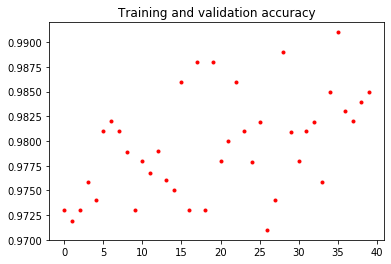

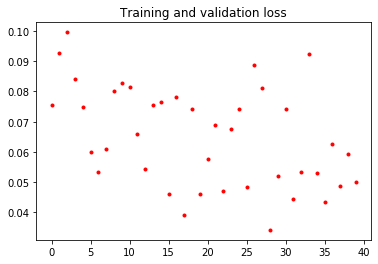

<Figure size 432x288 with 0 Axes>

In [12]:
# Plot the training and validation loss + accuracy
def plot_training(history):
    acc = history.history['acc']
#     val_acc = history.history['val_acc']
    loss = history.history['loss']
#     val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
#     plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss, 'r.')
#     plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.show()

    plt.savefig('acc_vs_epochs.png')
    
plot_training(history)

In [10]:
TEST_DIR = r"D:\NUS_TERM2_CA2\Validation"

test_generator = datagen.flow_from_directory(TEST_DIR,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE)

# Todo, add test
filenames = test_generator.filenames
nb_samples = len(filenames)

loss, acc = finetune_model.evaluate_generator(test_generator, workers=8, steps = nb_samples //BATCH_SIZE, verbose=1)
print('Loss is')
print(loss)
print('accuracy is')
print(acc)

Found 724 images belonging to 3 classes.
90/90 [==============================] - 18s 198ms/step
Loss is
0.05375597789705735
accuracy is
0.9847222222222223


In [ ]:
predict = finetune_model.predict_generator(test_generator,steps = nb_samples //BATCH_SIZE, verbose=1)
